# 一维卡尔曼滤波器

In [1]:
%matplotlib inline

import lean.book_format as book_format
book_format.set_style()

现在我们了解了离散贝叶斯滤波器和高斯，我们准备实现卡尔曼滤波器。我们将完全按照离散贝叶斯滤波器的方式执行此操作,而不是从方程开始，我们将根据对问题的推理逐步开发代码。

“一维”表示滤波器仅跟踪一个状态变量，例如 x 轴上的位置。在随后的章节中，我们将学习一种更通用的多维滤波器形式，它可以同时跟踪许多状态变量，例如位置、速度和加速度。回想一下，我们在g-h滤波器中使用速度来获得比单独跟踪位置更好的估计值。卡尔曼滤波器也是如此。

那么，为什么不直接跳入滤波器的多维形式呢？老实说，数学很困难，我开发滤波器的直观方法开始崩溃。这种数学模糊了允许卡尔曼滤波器工作的相当简单的原理。

因此，在本章中，我们将学习如何使用高斯来实现贝叶斯滤波器。这就是卡尔曼滤波器的全部内容 - 使用高斯的贝叶斯滤波器。在下一章中，我们将切换到多维形式，卡尔曼滤波器的全部力量将被释放！

## 一、问题描述



与离散贝叶斯滤波器一章一样，我们工作中，将在一个常常走廊里跟踪一个移动物体。假设在我们最新的黑客马拉松中，有人创建了一个RFID跟踪器，可以提供相当准确的狗的位置。传感器返回狗与走廊左端的距离（以米为单位）。因此，23.4 意味着狗距离走廊左端 23.4 米。

传感器并不完美。读数为 23.4 可能对应于狗在 23.7 或 23.0。但是，它不太可能对应于47.6的位置。黑客马拉松期间的测试证实了这一结果 - 传感器“合理”准确，虽然它有错误，但错误很小。此外，误差似乎均匀分布在真实位置的两侧;23 m 的位置同样可能被测量为 22.9 或 23.1。也许我们可以用高斯模型来建模。

我们预测狗正在移动。这个预测并不完美。有时我们的预测会超调，有时会低于。我们更有可能低于或超过一点点而不是很多。也许我们也可以用高斯来建模。

## 二、高斯信念

我们可以用高斯来表达我们对狗的位置的信念。假设我们相信我们的狗在 10 米处，并且该信念的方差为1 m$^2$, 或者 $\mathcal{N}(10,\, 1)$。概率密度PDF图如下：


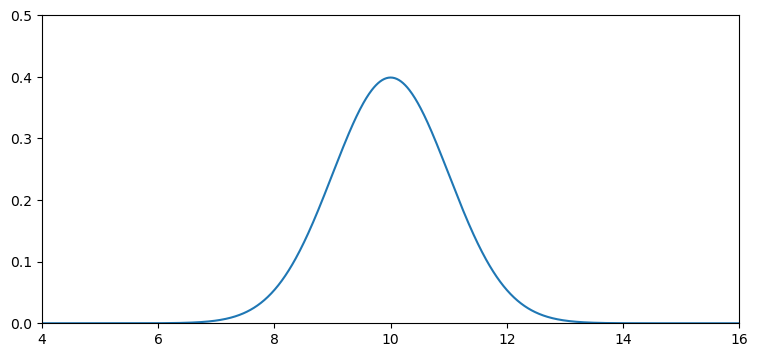

In [2]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图描绘了我们对狗的位置的不确定性。它代表了一种相当不准确的信念。虽然我们认为狗最有可能在 10 m 处，但 9 m 到 11 m 左右的任何位置也很有可能。假设狗站着不动，我们再次查询传感器。这次它返回 10.2 m。我们可以使用这些额外的信息来改进我们的估计吗？

直觉表明我们可以。考虑一下：如果我们读取传感器 500 次，每次它返回一个介于 8 和 12 之间的值，都以 10 为中心，我们应该非常确信狗接近 10。当然，可以有不同的解释。也许我们的狗以一种完全模拟正态分布随机抽取的方式随机来回徘徊。但这似乎极不可能——我从未见过狗这样做。让我们看看做500次实验，基于$\mathcal N(10, 1)$：



Mean of readings is 9.956


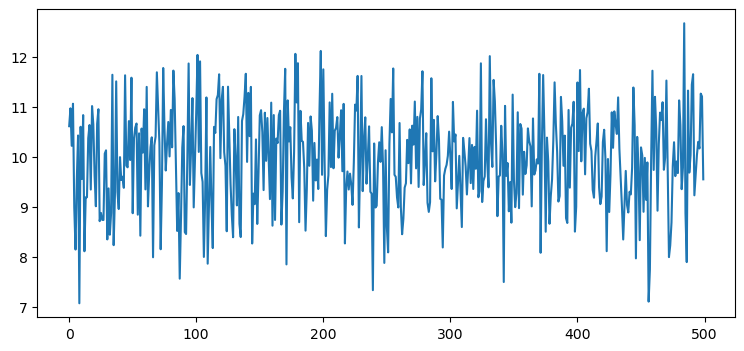

In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

目测这证实了我们的直觉——没有狗像这样移动。然而，嘈杂的传感器数据肯定是这样的。读数的计算平均值几乎正好是 10。假设狗站着不动，我们说狗在位置 10，方差为 1。

## 三、使用高斯概率进行跟踪

离散贝叶斯滤波器使用概率直方图来跟踪狗。直方图中的每个箱代表一个位置，它的值是狗处于该位置的概率。

跟踪是通过预测和更新的周期执行计算的。我们使用了方程式：

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

去计算新的概率分布。回想一下 $\bar{\mathbf x}$ 是 *先验*, $\mathcal L$ 是给定先验$\bar{\mathbf x}$情况下的测量*可能性*, $f_{\mathbf x}(\bullet)$ 是 *过程模型*, $\ast$ 表示 *卷积*. $\mathbf x$ 以粗体表示它是数字的直方图或向量。

这种方法有效，但是直方图显示狗可能同时在多个地方。此外，对于大型问题，计算速度非常慢。

我们可以用高斯 $\mathcal N(\mu, \sigma^2),$替换直方图 $\mathbf x$ 吗？绝对！我们已经学会了如何表达高斯信念。高斯，它就是单个数字对 $\mathcal N(\mu, \sigma^2),$ 可以替换整个概率直方图：


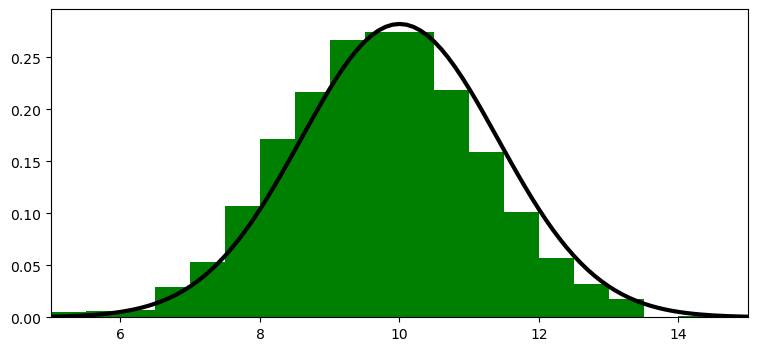

In [4]:
import lean.kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

我希望你看到它的力量。我们可以用一对数字替换数百到数千个数字：$x = \mathcal N(\mu, \sigma^2)$

高斯的尾部在两侧延伸到无穷大，因此它在直方图中包含任意多个条形。如果这代表了我们对狗在走廊中位置的信念，那么这个高斯涵盖了整个走廊（以及该轴上的整个范围）。我们认为狗很可能在 10 米的位置，但他可能在 8、14 米的位置，或者，以无限小的概率，在  $10^{80}$ 米的位置。

在本章中，我们将直方图替换为高斯图：

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

其中 $\oplus$ 和 $\otimes$旨在表达高斯上的某个未知运算符。我不会在本书的其余部分这样做，但下标$x_\mathcal{N}$表明是高斯的。

离散贝叶斯滤波器使用卷积进行预测。我们证明它使用了总概率定理，计算为总和，所以也许我们可以使用高斯叠加。它使用乘法将测量值合并到先验中，所以也许我们可以乘以高斯。会不会这么简单：

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

这只有在两个高斯的和和乘积是另一个高斯时才有效。否则在第一个纪元之后 $x$ 就不是高斯了，这个方案就分崩离析了。



## 四、使用高斯预测

我们使用牛顿运动方程根据当前速度和先前位置计算当前位置：

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

我已经放弃了符号 $f_x(\bullet)$，转而使用 $f_x$ 以保持方程整洁。

如果狗在 10 m 处，他的速度是 15 m/s，纪元长 2 秒，我们有

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

我们不确定他目前的位置和速度，所以这不行。我们需要用高斯来表达不确定性。

位置很容易。我们将  $x$ 定义为高斯。如果我们认为狗在 10 m 处，并且不确定性的标准差为 0.2 m，则得到 $x=\mathcal N(10, 0.2^2)$。

怎么描述它的运动中的不确定性呢？我们将 $f_x$ 定义为高斯。如果狗的速度是 15 m/s，epoch 是 1 秒，我们的不确定性的标准差是 0.7 m/s，我们得到 $f_x = \mathcal N (15, 0.7^2)$。

先验的方程为：

$$\bar x = x + f_x$$

两个高斯之和是多少？在最后一章中，我证明了：

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

这是个好消息;两个高斯之和是另一个高斯！

数学有效，但这是否直观有意义？想想这个抽象方程的物理表示。我们有

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

如果我们添加这些，我们会得到：

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

预测位置是前一个位置加上移动是有道理的。方差呢？对此很难形成直觉。但是，回想一下，使用离散贝叶斯滤波器的predict的函数，我们总是丢失信息。我们真的不知道狗在哪里移动，所以信心应该变小（方差变大）。$\sigma_{f_x}^2$ 是由于对运动的不完美预测而添加到系统中的不确定性量，因此我们将其添加到现有的不确定性中。

让我们利用 Python collection 模块中的 namedtuple 类来实现一个高斯对象.们可以使用元组实现高斯，其中$\mathcal N(10, 0.04)$在Python中被实现为`g = (10., 0.04)`。我们可以得到均值 `g[0]` 和方差 `g[1]`。

namedtuple工作原理与元组相同，只是您为其提供类型名称和字段名称。理解这一点并不重要，但我修改了该方法以使用本章中的符号显示其值。__repr__

In [5]:
from collections import namedtuple
gaussian = namedtuple("Gaussian", ["mean", "var"])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

现在我们可以创建一个高斯，并打印

In [6]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2*0.2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


我们可以用下标或字段名称访问均值和方差：

In [7]:
g1.mean, g1.var, g2[0], g2[1]

(3.4, 10.1, 4.5, 0.04000000000000001)

下面是我们对预测函数的实现，其中位置和运动是以高斯的形式($\mu$, $\sigma^2$)。

In [8]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

让我们测试一下。如果初始位置是高斯 $\mathcal N(10, 0.2^2)$，而运动是高斯$\mathcal N (15, 0.7^2)$ ，则先验是什么？

In [9]:
pos = gaussian(10., 0.2**2)
move = gaussian(15., 0.7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

先验指出，狗在 25 m 处，方差为 0.53 m$^2$ ，这和我们手动计算的一致。

## 五、使用高斯更新

离散贝叶斯滤波器将我们对狗位置的信念编码为概率直方图。分布是离散的和多模态的。它可以表达强烈的信念，即狗同时处于两个位置，并且位置是离散的。

我们建议用高斯图替换直方图。离散贝叶斯滤波器使用以下代码来计算后验：

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

其中，等式的实现是：

$$x = \| \mathcal L\bar x \|$$

我们刚刚证明了我们可以用高斯表示先验。可能性（likelihood）如何？可能性是给定当前状态(先验)的测量概率。我们已经学会了如何将测量值表示为高斯量。例如，也许我们的传感器指出狗在 23 m 处，标准偏差为 0.4 米。我们的测量值（以可能性表示）是 $z = \mathcal N (23, 0.16)$。

可能性和先验都是用高斯模型建模的。我们可以乘以高斯吗？两个高斯的乘积是另一个高斯吗？

前者是对的，后者几乎也是对的！在最后一章中，我证明了两个高斯的乘积与另一个高斯成正比。

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

我们可以立即推断出几件事。如果我们对结果进行归一化，则乘积是另一个高斯。如果一个高斯是可能性（likelihood），第二个高斯是先验（prior），则均值是先验和测量值的缩放和。方差是先验方差和度量方差的组合。最后，方差完全不受均值的影响！

我们用贝叶斯术语来表示，如下所示：

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

如果我们在一个函数gaussian_multiply()中实现它，我们可以将滤波器的更新步骤实现为：

In [10]:
# 高斯乘法
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    var = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, var)

# 基于高斯的update操作
def update(prior, likelihood):
    posterior = gaussian_multiply(prior, likelihood)
    return posterior

# 测试高斯更新函数
predicted_pos =  gaussian(10., 0.2**2)
measured_pos = gaussian(11., 0.1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

如果我们使用更具体的名称，也许这会更清楚：

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```

这不那么抽象，这可能有助于理解，但这是糟糕的编码实践。我们正在编写一个卡尔曼滤波器，可以解决任何问题，而不仅仅是在走廊里跟踪狗，所以我们不会使用带有“dog”的变量名称。此外，这种形式掩盖了我们将可能性（likelihood）乘以先验（prior）的事实。

我们已经实现了滤波器的大部分内容，但我担心这一步仍然有点令人困惑。我已经断言我们可以乘以高斯并且它正确地执行了更新步骤，但为什么这是正确的？让我们绕道而行，花一些时间研究高斯乘法。

## 六、了解高斯乘法

让我们绘制高斯乘法 $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$的概率密度pdf图 .你能在不看结果的情况下确定它的形状吗？新的含义应该是什么？曲线是更宽、更窄？还是与$\mathcal{N}(10,\, 1)$相同?

𝒩(μ=10.000, 𝜎²=0.500)


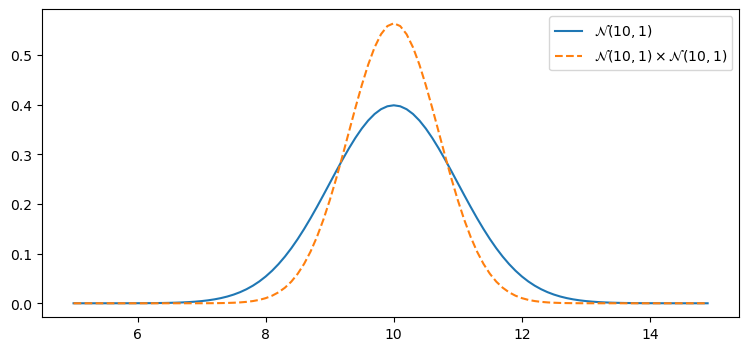

In [11]:
z = gaussian(10., 1.)
product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

乘法的结果比原始高斯更高更窄，但平均值保持不变。这符合你的直觉吗？

将高斯量视为两个测量值。如果我测量两次，每次得到 10 米，我应该得出结论，长度接近 10 米。因此，平均值应为 10。断定长度实际上是 11 或 9.5 是没有意义的。此外，我对两个测量比一个测量更有信心，因此结果的方差应该更小。

“测量两次，切割一次”（三思而后行）是一句众所周知的说法。高斯乘法是这个物理事实的数学模型。

我不太可能连续两次获得相同的测量结果。现在让我们绘制 pdf 的$\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$。你认为结果会是什么？想一想，然后看图表。

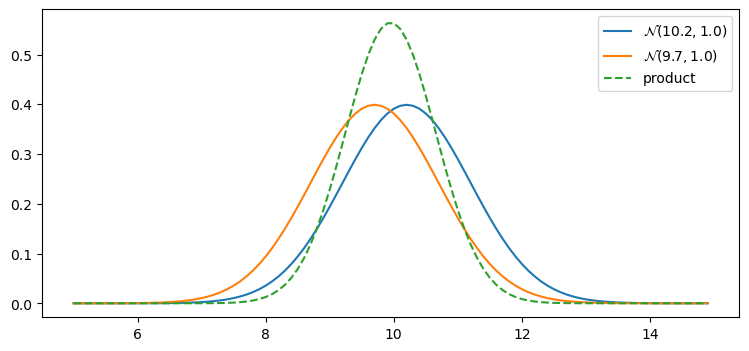

In [12]:
# 绘制高斯乘法的图像
def plot_products(g1, g2):
    plt.figure()
    product = gaussian_multiply(g1, g2)
    
    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))
    
    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))
    
    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend()
    
z1 = gaussian(10.2, 1.)
z2 = gaussian(9.7, 1.)

plot_products(z1, z2)
    

如果你让两个人测量一张桌子到墙的距离，一个人得到10.2米，另一个得到9.7米，你最好的猜测一定是平均值，如果你同样信任两者的技能，那就是9.95米。

回想一下 g-h 过滤器。我们一致认为，如果我在两个秤上称量自己，第一个读数为160磅，第二个读数为170磅，并且两者都同样准确，则最佳估计值为165磅。此外，我应该对 165 磅与 160 磅或 170 磅更有信心，因为我现在有两个读数，都接近这个估计值，增加了我对两者都不是大错特错的信心。

在更复杂的情况下，这变得违反直觉，所以让我们进一步考虑一下。也许更合理的假设是一个人犯了一个错误，真实距离是10.2或9.7，但肯定不是9.95。这当然是可能的。但我们知道我们有嘈杂的测量结果，所以我们没有理由认为其中一个测量值没有噪音，或者一个人犯了一个严重的错误，允许我们放弃他们的测量结果。鉴于所有可用信息，最佳估计值一定是 9.95。

在卡尔曼滤波器的更新步骤中，我们不合并两个测量值，而是合并一个测量值和未测量之前的先验估计值。我们根据g-h滤波器的这个逻辑。无论我们合并来自两个测量的信息，还是一个测量和一个预测，数学都是相同的。

让我们看看这个例子。我将创建一个相当不准确的先验 $\mathcal N(8.5, 1.5)$ 以及更准确的测量 $\mathcal N(10.2, 0.5).$ 我所说的“准确”是指传感器方差小于先验方差，而不是我以某种方式知道狗比 10.2 更接近 8.5。接下来，我将绘制反向关系：准确的先验 $\mathcal N(8.5, 0.5)$ 和不准确的测量$\mathcal N(10.2, 1.5)$。


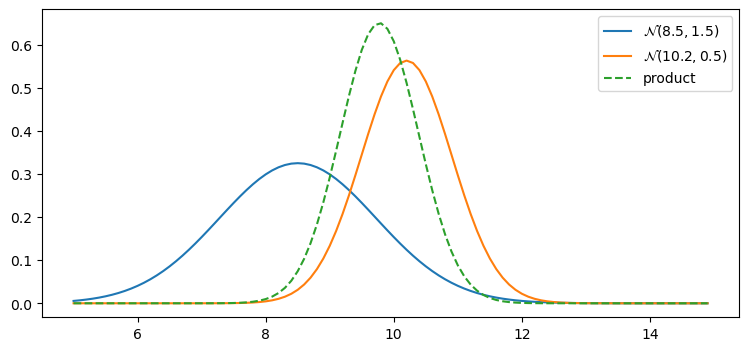

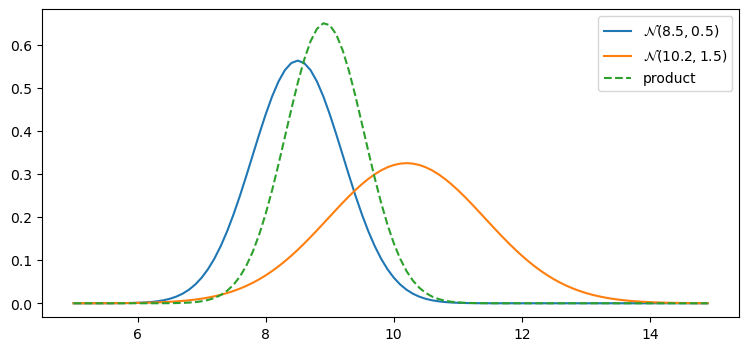

In [13]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

高斯乘积的结果是高于任一输入的。这是有道理的-我们已经合并了信息，因此我们的方差应该减少。请注意，结果更接近方差较小的输入。我们对这个价值（分布）更有信心，所以更重视它是有意义的。

它似乎有效，但它真的正确吗？关于这一点还有更多要说的，但我想让一个有效的滤波器运行，以便您可以具体体验它。之后，我们将重新审视高斯乘法并确定它为什么是正确的。

### 交互式示例

此交互式代码提供了滑块来更改相乘的两个高斯的均值和方差。当您移动滑块时，将重新绘制绘图。将光标放在代码单元格内，然后按 Ctrl+Enter 执行它。

In [14]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

## 七、第一个卡尔曼滤波器

让我们回到具体术语并实现卡尔曼滤波器。我们已经实现了update()和predict()函数。

我们只需要编写一些样板代码来模拟狗并创建测量值。我在kf_internal中放了一个DogSimulation类，以避免分心于这项任务。

此样板代码通过定义均值、方差和生成模拟的狗运动来设置问题。

In [15]:
import lean.kf_book.kf_internal as kf_internal
from lean.kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1.0                   # 过程模型的方差
sensor_var = 2.0                    # 传感器的方差，测量方差

x = gaussian(0.0, 20.0**2)          # 狗的初始位置,服从正态分布N(0, 20**2)

velocity = 1                        # 狗的行驶速度
dt = 1                              # 时间步长

process_model = gaussian(mean=velocity*dt, var=process_var)

# 模拟狗，获取传感器测量
dog = DogSimulation(
    x0=x.mean,
    velocity=process_model.mean,
    measurement_var=sensor_var,
    process_var=process_model.var
)

# 创建一个狗的测量位置的列表
zs = [dog.move_and_sense() for _ in range(10)]

这是卡尔曼滤波器

In [16]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# 在测量zs上执行卡尔曼滤波
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    
    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


这是滤波的动画。预测用红色三角形绘制。预测后，滤波器接收下一个测量值，绘制为黑色圆圈。然后，滤波之后在两者之间形成估计值。

In [17]:
from lean.kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# 保存输出在这些列表中，用于绘制图像
xs, predictions = [], []

process_model = gaussian(velocity*dt, process_var)

# 执行卡尔曼滤波
x = gaussian(0.0, 20.0**2)
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    
    x = update(prior, likelihood)
    
    # 保存结果
    predictions.append(prior.mean)              # 先验估计
    xs.append(x.mean)                           # 后验估计
    
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3))

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_filter(step)>

我已经绘制了先验（标记的预测）、测量值和滤波器输出。对于循环的每次迭代，我们形成一个先验，进行测量，从测量中形成可能性，然后将可能性合并到先验中。

如果您查看该图，您会发现滤波器的估计值始终介于测量值和预测值之间。回想一下，对于g-h滤波器，我们认为估计值必须始终在测量值和先验值之间。选择两个值之外的值是没有意义的。如果我预测10，但是测量是9，那么决定是在8或11是愚蠢的。

### 代码展示

现在让我们深入走进代码。

```python
process_var = 1.
sensor_var = 2.
```

这些是过程模型和传感器的方差。传感器方差的含义应该很清楚 - 它是每次测量中有多少方差。过程方差是过程模型中存在多少误差。我们预测，每一步狗都会向前移动一米。狗很少做我们期望的事情，像山丘或松鼠的气味会改变他的进步。如果这是一个接受数字命令的机器人，性能会好得多，也许方差会是 $\sigma^2=.05$。这些不是什么“魔法”的数字;方差的平方根是以米为单位的距离误差。只需插入数字即可轻松获得卡尔曼滤波器的工作，但如果数字不能反映现实，滤波器的性能就会很差。

```python
x = gaussian(0., 20.**2)
```

这是狗的初始位置，表示为高斯。位置为 0 米，方差为 400 m$^2$2，即 20 米的标准偏差。你可以把它想象成“我相信99.7%的准确率，位置是0正负60米”。这是因为对于高斯，99.7% 的值落在平均值 $\pm3\sigma$范围内。

```python
process_model = gaussian(velocity, process_var)
```

这是过程模型 - 描述我们认为狗如何移动。我怎么知道速度？魔法？把它当作一个预测，或者我们有一个辅助速度传感器。如果这是一个机器人，那么这将是机器人的控制输入。在后续章节中，我们将学习如何处理没有速度传感器或输入的情况，因此请暂时接受此简化。

这是过程模型 - 描述我们认为狗如何移动。我怎么知道速度？魔法？把它当作一个预测，或者我们有一个辅助速度传感器。如果这是一个机器人，那么这将是机器人的控制输入。在后续章节中，我们将学习如何处理没有速度传感器或输入的情况，因此请暂时接受此简化。

接下来，我们初始化仿真并创建 10 个测量值：

```python
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [dog.move_and_sense() for _ in range(10)]
```

现在我们进入我们的循环。predict() -> update() -> predict() -> update() -> ...

```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```

第一次通过循环，先验是prior(1.0, 401.0)，如打印的表格所示。在预测之后，我们认为狗处于 1.0米的位置，方差现在为 401，高于 400。方差变得更糟，这是在预测步骤中经常发生的情况，因为它涉及信息丢失。

然后，我们使用prior调用update()函数，并将先验作为狗的当前实际位置。

为此，我们得到的结果是 `z = 1.354, pos = (1.352, 1.990)`。

发生了什么事情？狗实际上处于 1.0，但由于传感器噪声，测量位置为 1.354。这与预测值 1 相去甚远。先验的方差为 401 m$^2$2。较大的方差意味着置信度非常低，因此筛选器估计位置非常接近测量值：1.352。

现在看方差：1.99 m$^2$。它从401 m$^2$大幅下降。为什么？好吧，RFID 的方差很小，为 2.0 m$^2$，所以相比于先验我们更信任它。但是，之前先验的信念确实包含一些有用的信息，因此我们的方差现在略小于 2.0。

现在程序不断循环，调用predict和update。到最后，最终估计位置(后验估计)为 15.053，实际位置(测量值)为 14.838。方差已收敛到 1.0。

现在看看图画。噪声测量值用黑色圆圈绘制，滤波器结果用蓝色实线绘制。测量和预测两者都非常嘈杂，但请注意测量值的噪音有多大。我用红色三角形绘制了预测（prior）。估计值始终介于先前和测量值之间。这是您的第一个卡尔曼滤波器，它似乎有效！

滤波仅在几行代码中实现。大多数代码要么是初始化，要么是数据存储，要么是模拟狗的运动，要么是打印结果。执行过滤的代码非常简洁：

```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```

如果我们不使用 predict和update函数，代码可能是：

```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```  

只需 5 行非常简单的数学运算即可实现整个滤波器！

在这个例子中，我只绘制了 10 个数据点，因此 print 语句的输出不会让我们不知所措。现在，让我们看一下滤波器的性能以及更多数据。方差绘制为虚线之间的浅黄色阴影区域。我增加了过程和传感器方差的大小，以便它们更容易在图表上看到 - 对于真正的卡尔曼滤波器，您当然不会随机更改这些值。


	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


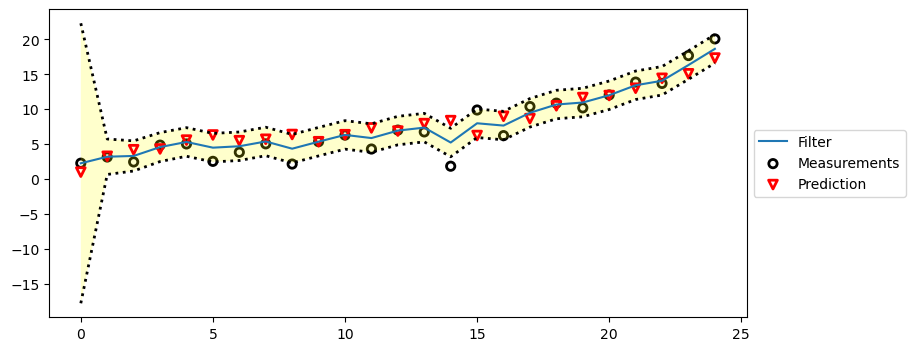

In [26]:
process_var = 2.0
sensor_var = 4.5

x = gaussian(0.0, 400.0)
process_model = gaussian(1.0, process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    priors[i] = prior                           # 先验估计
    
    xs[i] = x                                   # 后验估计
    
book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

在这里，我们可以看到方差在第9个迭代步开始收敛到2.1623。这意味着我们对狗的位置的估计非常有信心。它的标准差是 $\sigma=1.47$米。将其与传感器的 $\sigma=2.12$ 米。由于我们对初始位置的不确定性，前几次测量不确定，但滤波器会迅速收敛到估计值方差低于传感器的方差！

此代码完全实现了卡尔曼滤波器。如果你试图阅读文献，你可能会感到惊讶，因为这看起来与那些书中无休止的数学页面完全不同。只要我们关心使用方程而不是推导它们，这个话题就是很容易懂的。此外，我希望你会同意你对正在发生的事情有一个很好的直觉把握。我们用高斯来代表信念，随着时间的推移，它们会变得更好，因为更多的测量意味着我们有更多的数据可以使用。

### 练习：修改方差值

修改 process_var 和 sensor_var 的值，并注意对滤波器和方差的影响。哪个对方差收敛的影响更大？例如，那个导致较小的方差：

```python
process_var = 40
sensor_var = 2
```
    
or:

```python
process_var = 2
sensor_var = 40
```

**通过我的实验对比，发现传感器方差越小，最终的估计方差收敛越小**

### 卡尔曼滤波动画

如果您在浏览器中阅读本文，您将能够看到过滤器跟踪狗的动画。

<img src='lean/animations/05_dog_track.gif'>

上图以绿色显示滤波器的输出，用红色虚线显示测量值。下图显示了每一步的高斯。

当跟踪首次开始时，您可以看到测量值与初始预测有很大差异。此时，高斯概率很小（曲线又低又宽），因此滤波器不信任其预测。因此，滤波器会大量调整其估计值。随着滤波器的更新，您可以看到，随着高斯变高，表明估计的确定性更高，滤波器的输出变得非常接近一条直线。在x = 15的时候，您可以看到测量中存在大量噪声，但与第一次噪声测量的变化相比，滤波器对它的反应并不大。




## 八、卡尔曼增益

我们看到滤波器确实有效。现在让我们回到数学上来了解发生了什么。后验估计 $x$ 计算为可能性(likelihood)乘以前验(prior)($\mathcal L \bar x$)，两者都是高斯。

因此，后验的均值由下式给出：

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

我使用下标 $𝑧$ 表示测量值。我们可以将其重写为：

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

在这种形式中，很容易看出我们正在按权重缩放测量值和先验值：

$$\mu = W_1 \mu_z + W_2 \bar\mu$$

权重之和为 1，因为分母是一个归一化项。我们引入一个新术语，$K=W_1$，为我们提供：

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

其中

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ 是卡尔曼的收益。这是卡尔曼滤波器的关键。它是一个缩放项，在两者之间选择一个值 $\mu_z$ 和 $\bar\mu$。

让我们举几个例子。如果测量(likelihood)的精度是先验(prior)的九倍，则  $\bar\sigma^2 = 9\sigma_z^2$。

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

因此 $K = \frac 9 {10}$ ，为了形成后验，我们采用十分之九的测量和先验的十分之一。

如果测量和先验同样准确，则 $\bar\sigma^2 = \sigma_z^2$。

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

这是两个平均值的平均值。取两个同样准确的值的平均值是直观的。

我们还可以用卡尔曼增益来表示方差：

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

我们可以通过查看此图表来理解这一点：

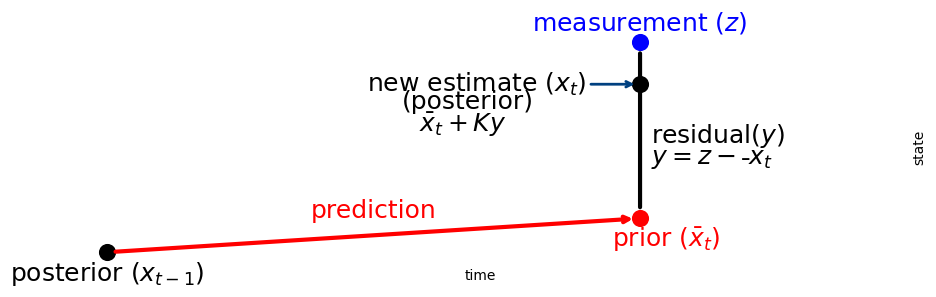

In [27]:
import lean.kf_book.book_plots as book_plots
book_plots.show_residual_chart()

卡尔曼增益 $𝐾$ 是沿残差选择值的比例因子。这是一种选择，它与update()和predict()的实现等效。

In [28]:
def update(prior, measurement):
    x, P = prior                        # 先验的均值和方差
    z, R = measurement                  # 测量的均值和方差
    
    y = z - x                           # 测量与先验的残差
    K = P / (P + R)                     # 卡尔曼增益
    
    x = x + K*y                         # 后验估计均值
    P = (1 - K) * P                     # 后验估计的方差
    
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior                        # 上一轮的后验估计
    dx, Q = movement                        # 过程模型
    
    x = x + dx                              # 预测的均值
    P = P + Q                               # 预测的方差
    
    return gaussian(x, P)                   # 新的预测，也就是本轮的先验

为什么我用这种形式写它，为什么我选择这些可怕的变量名称？几个相关原因。大多数书籍和论文都以这种形式呈现卡尔曼滤波器。我从贝叶斯原理推导出滤波器并非不为人所知，但它的使用频率并不高。替代推导自然会导致这种形式的方程。此外，多元卡尔曼滤波器的方程看起来几乎与这些方程完全相同。因此，您需要学习和理解它们。

名称`z`, `P`, `Q`, 和 `R`从何而来？你将在本书的其余部分看到它们被使用。在文献中 $R$ 几乎普遍用于测量噪声， $𝑄$ 用于过程噪声和 $𝑃$ 对于状态的方差。用 $𝑧$ 表示测量是常见的，尽管不是通用的。几乎你读过的每本书和每篇论文都会使用这些变量名称。习惯他们。

这也是一种思考滤波的有效方法。这就是我们对g-h滤波器的推理方式。它强调采取剩余 $y = \mu_z - \bar\mu$，将卡尔曼增益作为我们在先验和测量中的不确定性的比率  $K = P/(P+R)$ ，并通过添加 $Ky$ 到前面。

贝叶斯推导方面在这种形式中被忽略了，事实上，我们将可能性(likelihood)乘以先验(prior)。这两个观点是等价的，因为数学是相同的。我选择了贝叶斯方法，因为我认为它对概率推理有了更直观而深刻的理解。这种替代形式使用 $𝐾$深入了解所谓的正交投影方法。卡尔曼博士在发明这个滤波器时使用了这个推导，而不是贝叶斯推理。在接下来的几章中，您将对此了解更多。

## 九、算法的完整描述


回想一下我们用于g-h滤波器的图像：

<img src="lean/figs/residual_chart.png">

在本章中，我们一直在做同样的事情。卡尔曼滤波器进行预测，再进行测量，然后在两者之间的某个地方形成新的估计。

理解这一点非常重要：本书中的每个滤波器都实现了相同的算法，只是具有不同的数学细节。数学在后面的章节中可能会变得具有挑战性，但这个想法很容易理解。

重要的是要看到特定滤波器方程的细节，并了解方程正在计算的内容以及原因。有大量的滤波器，它们都使用不同的数学来实现相同的算法。数学的选择会影响结果的质量以及可以表示的问题，但不会影响基本思想。

以下是通用算法：

**初始化**
- 1.初始化滤波器状态
- 2.初始化状态信念(方差)

**预测**
- 1.使用系统行为(过程模型)去预测下一个时间步的滤波器状态
- 2.调整信念(方差)用以解释预测中的不确定性

**更新**
- 1.获取测量及其相关方差
- 2.计算测量与先验估计之间的残差
- 3.计算缩放系数(卡尔曼系数)，根据测量和预测的方差
- 4.根据卡尔曼系数，在测量和预测之间设置滤波器状态(指后验估计的均值)
- 5.根据测量中的确信程度(方差)，更新后验估计的状态方差

您将很难找到不适合这种形式的贝叶斯过滤算法。一些滤波器将不包括某些方面，例如预测中的误差，而且其他滤波器将具有非常复杂的计算方法，但这就是它们所做的。

单变量卡尔曼滤波器的方程为：

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

